In [18]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp # numerical ODE solver
from scipy.optimize import minimize # for torque optimization
import matplotlib.pyplot as plt

# === Physical and Inertial Parameters ===
M = 70.0
H = 1.75
L1, L2, L3 = 0.245 * H, 0.246 * H, 0.152 * H # L1 = Femur length, L2 = Tibia Febula length, L3 = foot length
m1, m2, m3 = 0.1 * M, 0.0465 * M, 0.0145 * M # m1, m2, m3 = weight of L1, L2, L3 parts

# l1, l2, l3 needs to be changed to 0.5 * L1/ L2/ L3
l1, l2, l3 = 0.433 * L1, 0.433 * L2, 0.5 * L3 # l1, l2, l3 = center of mass of L1, L2, L3 parts

# Segment moment of inertia
J1 = (1/12) * m1 * L1**2 
J2 = (1/12) * m2 * L2**2
J3 = (1/12) * m3 * L3**2

g = 9.81

# joint dampers 
b1, b2, b3 = 0.05, 0.03, 0.02

In [19]:
# Precomputed constants
# These constants simplify the dynamic equations

c1 = m1*l1**2 + m2*L1**2 + m3*L1**2 + J1
c2 = m2*L1*l2
c3 = m3*L1*L2
c4 = m3*L1*l3
c5 = m1*g*l1
c6 = m2*g*L1
c7 = m3*g*L1
c8 = m2*l2**2 + m3*L2**2 + J2
c9 = m3*L2*l3
c10 = m2*g*l2
c11 = m3*g*L2
c12 = m3*l3**2 + J3
c13 = m3*g*l3


In [20]:
# === Dynamics ===

# Inputs: time t, state vector [theta1, theta2, theta3, dtheta1, dtheta2, dtheta3], and torques T = [T1, T2, T3].

# Builds:

# A: mass-inertia matrix.
# b: includes gravity, damping, torque terms.
# Solves A·dd(theta) = b for angular accelerations ddtheta

def lower_limb_dynamics(t, state, T):
    T1, T2, T3 = T
    theta1, theta2, theta3, dtheta1, dtheta2, dtheta3 = state
    A = np.array([
        [c1, (c2 + c3) * np.cos(theta1 - theta2), c4 * np.cos(theta1 - theta3)],
        [(c2 + c3) * np.cos(theta1 - theta2), c8, c9 * np.cos(theta2 - theta3)],
        [c4 * np.cos(theta1 - theta3), c9 * np.cos(theta2 - theta3), c12]
    ])
    b = np.array([
        -(c2 + c3) * dtheta2**2 * np.sin(theta1 - theta2) - c4 * dtheta3**2 * np.sin(theta1 - theta3) - (c5 + c6 + c7) * np.sin(theta1) + T1 - b1 * dtheta1 - b2 * (dtheta1 - dtheta2),
        (c2 + c3) * dtheta1**2 * np.sin(theta1 - theta2) - c9 * dtheta3**2 * np.sin(theta2 - theta3) - (c10 + c11) * np.sin(theta2) + T2 - b2 * (dtheta2 - dtheta1) - b3 * (dtheta2 - dtheta3),
        c9 * dtheta2**2 * np.sin(theta2 - theta3) + c4 * dtheta1**2 * np.sin(theta1 - theta3) - c13 * np.sin(theta3) + T3 - b3 * (dtheta3 - dtheta2)
    ])
    ddtheta = np.linalg.solve(A, b)
    return [dtheta1, dtheta2, dtheta3, ddtheta[0], ddtheta[1], ddtheta[2]]


In [24]:
# === Cost Function ===
def cost_function(T, initial_state, t_eval, real_data):
    sol = solve_ivp(lower_limb_dynamics, (t_eval[0], t_eval[-1]), initial_state, t_eval=t_eval, args=(T,), method='RK45', rtol=1e-6)
    
    sim_data = np.degrees(sol.y[:3, :]).T # Simulated data converted to degrees
    error = sim_data - real_data 
    # return np.sum(error**2)
    return np.mean(error**2)


In [25]:
# === Load Real Joint Angle Data ===
real_data = pd.read_csv("joint_angle_data.csv")  # Columns: ['time', 'theta1', 'theta2', 'theta3']
t_eval = real_data['time'].to_numpy()
real_angles = real_data[['theta1', 'theta2', 'theta3']].to_numpy()  # in degrees


In [26]:
# === Initial State ===
theta_init = np.radians(real_angles[0])  # Initial angles
dtheta_init = [0, 0, 0]  # You can modify based on estimated angular velocity
initial_state = list(theta_init) + dtheta_init


In [30]:
# === Optimization ===
T_init = [1.0, 1.0, 1.0]  # Initial guess for torques
bounds = [(0, 10), (0, 10), (0, 10)]  # Realistic torque bounds 

res = minimize(cost_function, T_init, args=(initial_state, t_eval, real_angles), bounds=bounds, method='L-BFGS-B')
optimized_T = res.x

print("\nOptimized Torques:")
print(f"T1 = {optimized_T[0]:.2f} Nm, T2 = {optimized_T[1]:.2f} Nm, T3 = {optimized_T[2]:.2f} Nm")



Optimized Torques:
T1 = 10.00 Nm, T2 = 9.54 Nm, T3 = 1.06 Nm


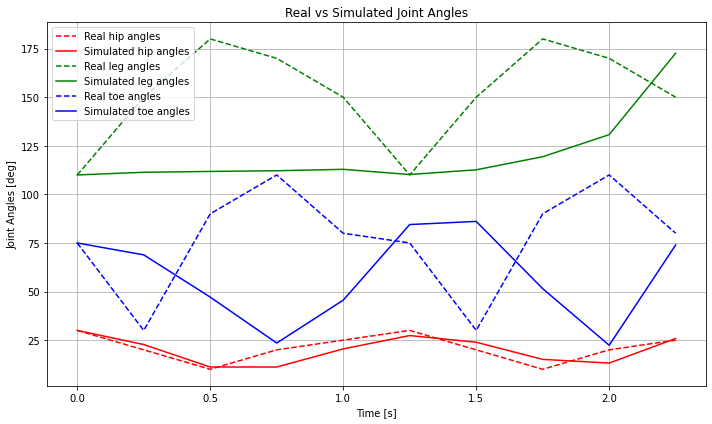

In [35]:
# === Simulate with Optimized Torques ===
sol = solve_ivp(lower_limb_dynamics, (t_eval[0], t_eval[-1]), initial_state, t_eval=t_eval, args=(optimized_T,))
sim_angles = np.degrees(sol.y[:3, :]).T

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(t_eval, real_angles[:, 0], 'r--', label='Real hip angles')
plt.plot(t_eval, sim_angles[:, 0], 'r-', label='Simulated hip angles')
plt.plot(t_eval, real_angles[:, 1], 'g--', label='Real leg angles')
plt.plot(t_eval, sim_angles[:, 1], 'g-', label='Simulated leg angles')
plt.plot(t_eval, real_angles[:, 2], 'b--', label='Real toe angles')
plt.plot(t_eval, sim_angles[:, 2], 'b-', label='Simulated toe angles')
plt.xlabel("Time [s]")
plt.ylabel("Joint Angles [deg]")
plt.title("Real vs Simulated Joint Angles")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
